In [1]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import csv
import random
import pickle as pkl
import pandas as pd
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras import layers
import matplotlib.pyplot as plt
tf.keras.backend.clear_session()  # For easy reset of notebook state.

In [2]:
class Linear(layers.Layer):
    '''
    Class for initializing a Layer in Neural Network
    '''
    def __init__(self, units=32):
        '''
        constructor
        :param units:  number of nodes in the layer
        '''
        super(Linear, self).__init__()
        self.units = units

    def build(self, input_shape):
        '''
        Initializes the weight and bias values of the layer
        :param w:  weights
        :param b:  bias
        '''
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='random_normal',
                                 trainable=True)

    def call(self, inputs):
        '''
        layer output
        '''
        return tf.matmul(inputs, self.w) + self.b

In [20]:
class MLPBlock(layers.Layer):
    '''
    Neural Network Block
    '''
    def __init__(self):
        '''
        Architecture of the neural network i.e.
        number of layers and nodes in each layer
        '''
        super(MLPBlock, self).__init__()
        self.layers = []     
        self.layers.append(Linear(312))
        self.layers.append(Linear(128))
        self.layers.append(Linear(1))

    def call(self, inputs):
        '''
        Forward pass of the neural network
        '''
#         inputs = tf.reshape(inputs, (inputs.shape[0], -1))
        x = self.layers[0](inputs)
        x = tf.nn.relu(x)
        x = self.layers[1](x)
        x = tf.nn.relu(x)
        x = self.layers[2](x)
        x = tf.nn.sigmoid(x)
        return x

In [4]:
def divide_chunks(l, n): 
    '''
    Divides a list into batches of given size
    '''
    # looping till length l 
    for i in range(0, len(l), n):  
        yield l[i:i + n] 

In [14]:
def custom_bce(p, x, offset=1e-7): #1e-10
    p_ = tf.clip_by_value(p, offset, 1 - offset)
#     print('p,x:', p.shape, x.shape)
    vec_bce = -tf.reduce_sum(x * tf.math.log(p_) + (1.0 - x) * tf.math.log(1.0 - p_), axis=1)
    return tf.reduce_sum(vec_bce)/x.shape[0]

In [6]:
def mix(a, n):
    '''
    creates a batch with 0's first and 1's next
    '''
    m = len(a)//2
    for i in range(0, m, n):
        if i+n > m:
            n = m-i
        yield np.concatenate((a[i:i+n], a[m+i:m+i+n]))

In [6]:
def relabel(labels):
    '''
    task wise relabel the dataset as combination of 0's and 1's
    '''
    new_labels = np.empty((0, labels.shape[0]))
    for task in range(10):
        positives = np.where(labels[:,task] == 1)[0]
        task_labels = np.zeros(labels.shape[0])
        task_labels[positives] = 1
        new_labels = np.vstack((new_labels, task_labels))
    new_labels = tf.convert_to_tensor(new_labels, dtype=tf.float32)
    return new_labels
    
def load_and_preprocess_data(name='mnist'):
    '''
    load the data and preprocess it by relabeling
    '''
    if name=='mnist':
        data = keras.datasets.mnist
    else:
        data = keras.datasets.fashion_mnist
    (train_images, train_labels), (test_images, test_labels) = data.load_data()
    train_images = train_images / 255.0
    test_images = test_images / 255.0
    train_images = np.reshape(train_images, [train_images.shape[0], -1])
    test_images = np.reshape(test_images, [test_images.shape[0], -1])
    
    indexes = np.arange(test_images.shape[0])
    for _ in range(5): indexes = np.random.permutation(indexes)  # shuffle 5 times!
    test_images = test_images[indexes]
    test_labels = test_labels[indexes]
    
    # 'split' into cross-val & test sets (use 6000 records in cross-val set)    
    val_count = int(0.8*test_labels.shape[0])
    val_images = test_images[:val_count]
    val_labels = test_labels[:val_count]
    test_images = test_images[val_count:]
    test_labels = test_labels[val_count:]
    
#     print('train_labels:', train_labels.shape)
    train_labels = relabel(train_labels)
    test_labels = relabel(test_labels)
    val_labels = relabel(val_labels)
    
    return (train_images, train_labels), (val_images, val_labels), (test_images, test_labels)

In [7]:
def batch_loader(labels, batch_size, class_bal=False):
    '''
    load random batches of data
    '''
    # if class balance is not required in every batch
    if not class_bal:
        indices = np.arange(labels.shape[0])
        for _ in range(5): np.random.shuffle(indices)
        batches = np.asarray(list(divide_chunks(indices, batch_size)))
        return batches
    
    # if class balance is needed in every batch
    else:
        positives = np.where(labels==1)[0]
        negatives = np.arange(labels.shape[0])
        negatives = np.delete(negatives, positives)
        np.random.shuffle(negatives)
        np.random.shuffle(positives)
        task_batch = []
        # create batches by iteratively scraping out chunks out of positives array
        while positives.shape[0] > 0:
            if len(positives) >= batch_size/2:
                # create a batch such that positive (batch_size/2) is added with sampled negatives (batch_size/2)
                temp = np.concatenate((positives[:batch_size//2], np.random.choice(negatives, batch_size//2)))
                positives = positives[batch_size//2: ]
            else:
                # for the last batch where no. of positive could be < batch_size
                temp = np.concatenate((positives, np.random.choice(negatives, len(positives))))
                positives = np.array([])
            np.random.shuffle(temp)
            task_batch.append(temp)
        return np.asarray(task_batch)

In [17]:
trainX = pd.read_csv('datasets/mnist/trainX.tsv', sep="\t", header=None, index_col=False).to_numpy()
trainY = pd.read_csv('datasets/mnist/trainY.tsv', sep="\t", header=None, index_col=False).to_numpy()
testX = pd.read_csv('datasets/mnist/testX.tsv', sep="\t", header=None, index_col=False).to_numpy()
testY = pd.read_csv('datasets/mnist/testY.tsv', sep="\t", header=None, index_col=False).to_numpy()
validX = pd.read_csv('datasets/mnist/validX.tsv', sep="\t", header=None, index_col=False).to_numpy()
validY = pd.read_csv('datasets/mnist/validY.tsv', sep="\t", header=None, index_col=False).to_numpy()

trainY = relabel(trainY)
testY = relabel(testY)
validY = relabel(validY)

In [21]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2)
bce = tf.keras.losses.BinaryCrossentropy()
net = MLPBlock()
n_tasks = 2
n_epochs = 5

# declare array for collecting train loss
# train_losses[t] = [n_epochs x n_tasks]
train_losses = {}
test_losses = {}
valid_losses = {}
train_accuracy = {}
valid_accuracy = {}
test_accuracy = {}
for t in range(n_tasks):
    train_losses[t] = []
    valid_losses[t] = []
    train_accuracy[t] = []
    valid_accuracy[t] = []
    test_losses[t] = []
    test_accuracy[t] = []
    
# calculate b_bar loss
for task in range(n_tasks):
    train_loss = 0
    train_acc = 0
    size = 0
    batches = batch_loader(trainY[task], 50, class_bal=True)
    for batch in batches:
        output = net(trainX[batch])
        size += batch.shape[0]
        temp = trainY[task, batch].reshape(output.shape)
        temp = tf.cast(temp, dtype=tf.float32)
        train_loss += custom_bce(temp, output).numpy() * batch.shape[0]
        output = output.numpy().reshape(-1)
        output[output >= 0.5] = 1
        output[output < 0.5] = 0
        train_acc += np.sum(output == trainY[task, batch])
    train_losses[task].append(train_loss/size)
    train_accuracy[task].append(train_acc/size)
    
    valid_loss = 0
    valid_acc = 0
    size = 0
    batches = batch_loader(validY[task], 50, class_bal=True)
    for batch in batches:
        output = net(validX[batch])
        size += batch.shape[0]
        valid_loss += custom_bce(validY[task, batch].reshape(output.shape), output).numpy() * batch.shape[0]
        output = output.numpy().reshape(-1)
        output[output >= 0.5] = 1
        output[output < 0.5] = 0
        valid_acc += np.sum(output == validY[task, batch])
    valid_losses[task].append(valid_loss/size)
    valid_accuracy[task].append(valid_acc/size)

# train and calculate BWT, FWT
for task in range(n_tasks):
    for epoch in range(n_epochs):
        batches = batch_loader(trainY[task], 50, class_bal=True)
        for batch in batches:
            with tf.GradientTape() as tape:
                # model output
                output = net(trainX[batch])
                # calculate batch loss
                batch_loss = custom_bce(trainY[task, batch].reshape(output.shape), output)
            # calculate gradients w.r.t. batch loss
            grads = tape.gradient(batch_loss, net.trainable_weights)
            optimizer.apply_gradients(zip(grads, net.trainable_weights))

        for t in range(n_tasks):
            loss = 0
            train_acc = 0
            size = 0
            batches = batch_loader(trainY[t], 50, class_bal=True)
            for batch in batches:
                output = net(trainX[batch])
#                 print('task %s= output:' % (task, output))
                size += batch.shape[0]
                loss += custom_bce(trainY[t, batch].reshape(output.shape), output).numpy() * batch.shape[0]
                output = output.numpy().reshape(-1)
                output[output >= 0.5] = 1
                output[output < 0.5] = 0
                train_acc += np.sum(output == trainY[t, batch])
            train_losses[t].append(loss/size)
            train_accuracy[t].append(train_acc/size)
        
        for t in range(n_tasks):
            valid_loss = 0
            valid_acc = 0
            size = 0            
            batches = batch_loader(validY[t], 50, class_bal=True)
            for batch in batches:
                output = net(validX[batch])
                size += batch.shape[0]
                valid_loss += custom_bce(validY[t, batch].reshape(output.shape), output).numpy() * batch.shape[0]
                output = output.numpy().reshape(-1)
                output[output >= 0.5] = 1
                output[output < 0.5] = 0
                valid_acc += np.sum(output == validY[t, batch])
            valid_losses[t].append(valid_loss/size)
            valid_accuracy[t].append(valid_acc/size)
    
        print('----- epoch %s completed -----' % (epoch))

    print('--------------------- Task %s completed ---------------------' % task)
    
    
# plot_losses(train_losses, valid_losses, norms_per_epoch)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got array([45078,  5194, 35739, 12248, 29991, 15064, 13003, 28763, 22846,
       17257, 26286,  2826,  5881, 11225,  9451, 20088,  6140, 24790,
       48439, 29559, 28365, 45097, 35775, 12080, 45366,  6176, 39105,
       44743, 26826, 19038,  5027, 23464, 44839, 12374, 40367, 10376,
        8809, 21608, 39028, 46625, 32950, 26277,  4325, 41012, 10612,
       18612, 45334,  3877,   855, 30220])

In [64]:
for t in range(n_tasks):
    test_loss = 0
    test_acc = 0
    size = 0            
    batches = batch_loader(testY[t], 50, class_bal=True)
    for batch in batches:
        output = net(testX[batch])
        size += batch.shape[0]
        test_loss += bce(testY[t, batch].reshape(output.shape), output).numpy() * batch.shape[0]
        output = output.numpy().reshape(-1)
        output[output >= 0.5] = 1
        output[output < 0.5] = 0
        test_acc += np.sum(output == testY[t, batch])
    test_losses[t].append(test_loss/size)
    test_accuracy[t].append(test_acc/size)

# test_acc /= size
# test_loss /= size
# print('\n\n\n################### Test Results ###################')
# print('average accuracy:', acc/size)
# print('average accuracy:', test_acc)
# print('counts:', counts)
# print('Test Loss: ', test_loss)




################### Test Results ###################
average accuracy: 0.985204081632653
counts: {0: 0, 1: 0}


In [ ]:
data_dict = {'train_loss': train_losses,
             'valid_loss': valid_losses,
             'test_loss': test_losses,
             'train_acc':train_accuracy,
             'test_acc': test_accuracy,
             'valid_acc': valid_accuracy
            }
pkl.dump(data_dict, open('mnist_data_dict.pkl', 'wb'))
print('Experiment completed')

In [2]:
data_dict = pkl.load(open('results/mnist_data_dict.pkl', 'rb'))
data_dict.keys()

dict_keys(['train_loss', 'valid_loss', 'test_loss', 'train_acc', 'test_acc', 'valid_acc'])

<IPython.core.display.Javascript object>


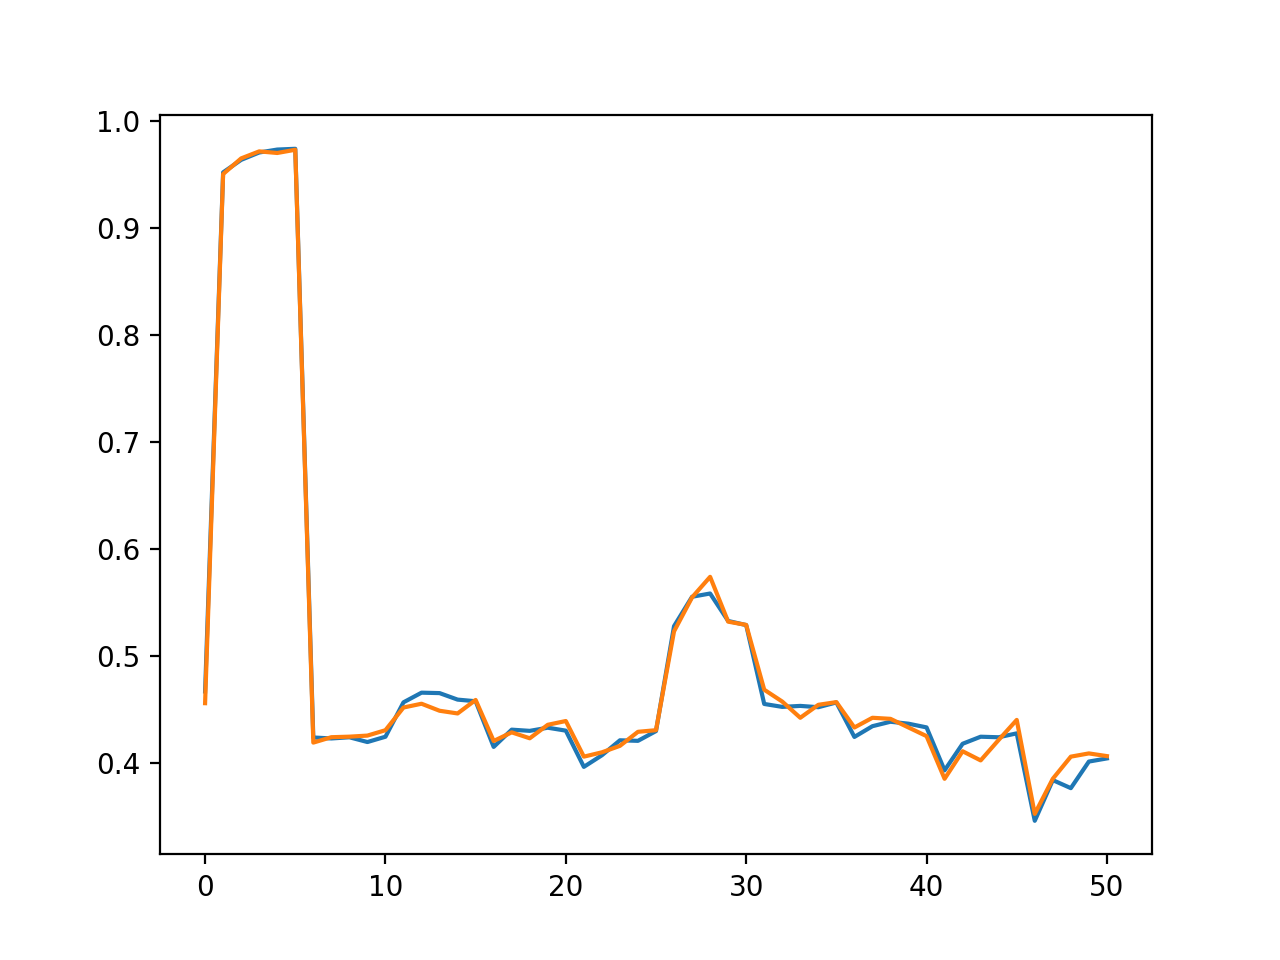

In [8]:
plt.plot(data_dict['train_acc'][0])
plt.plot(data_dict['valid_acc'][0])
plt.show()

<IPython.core.display.Javascript object>


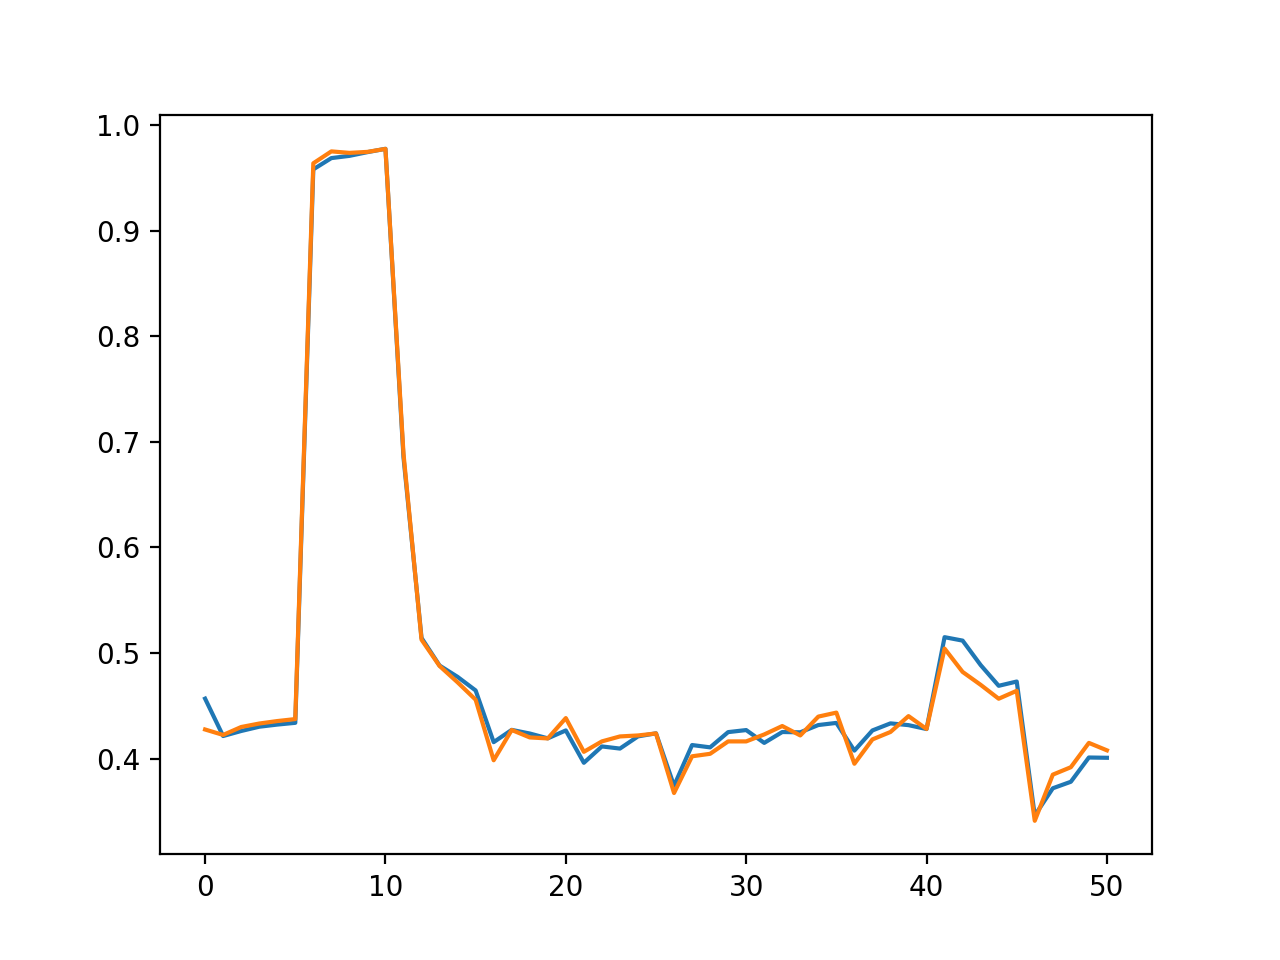

In [10]:
plt.plot(data_dict['train_acc'][1])
plt.plot(data_dict['valid_acc'][1])
plt.show()

<IPython.core.display.Javascript object>


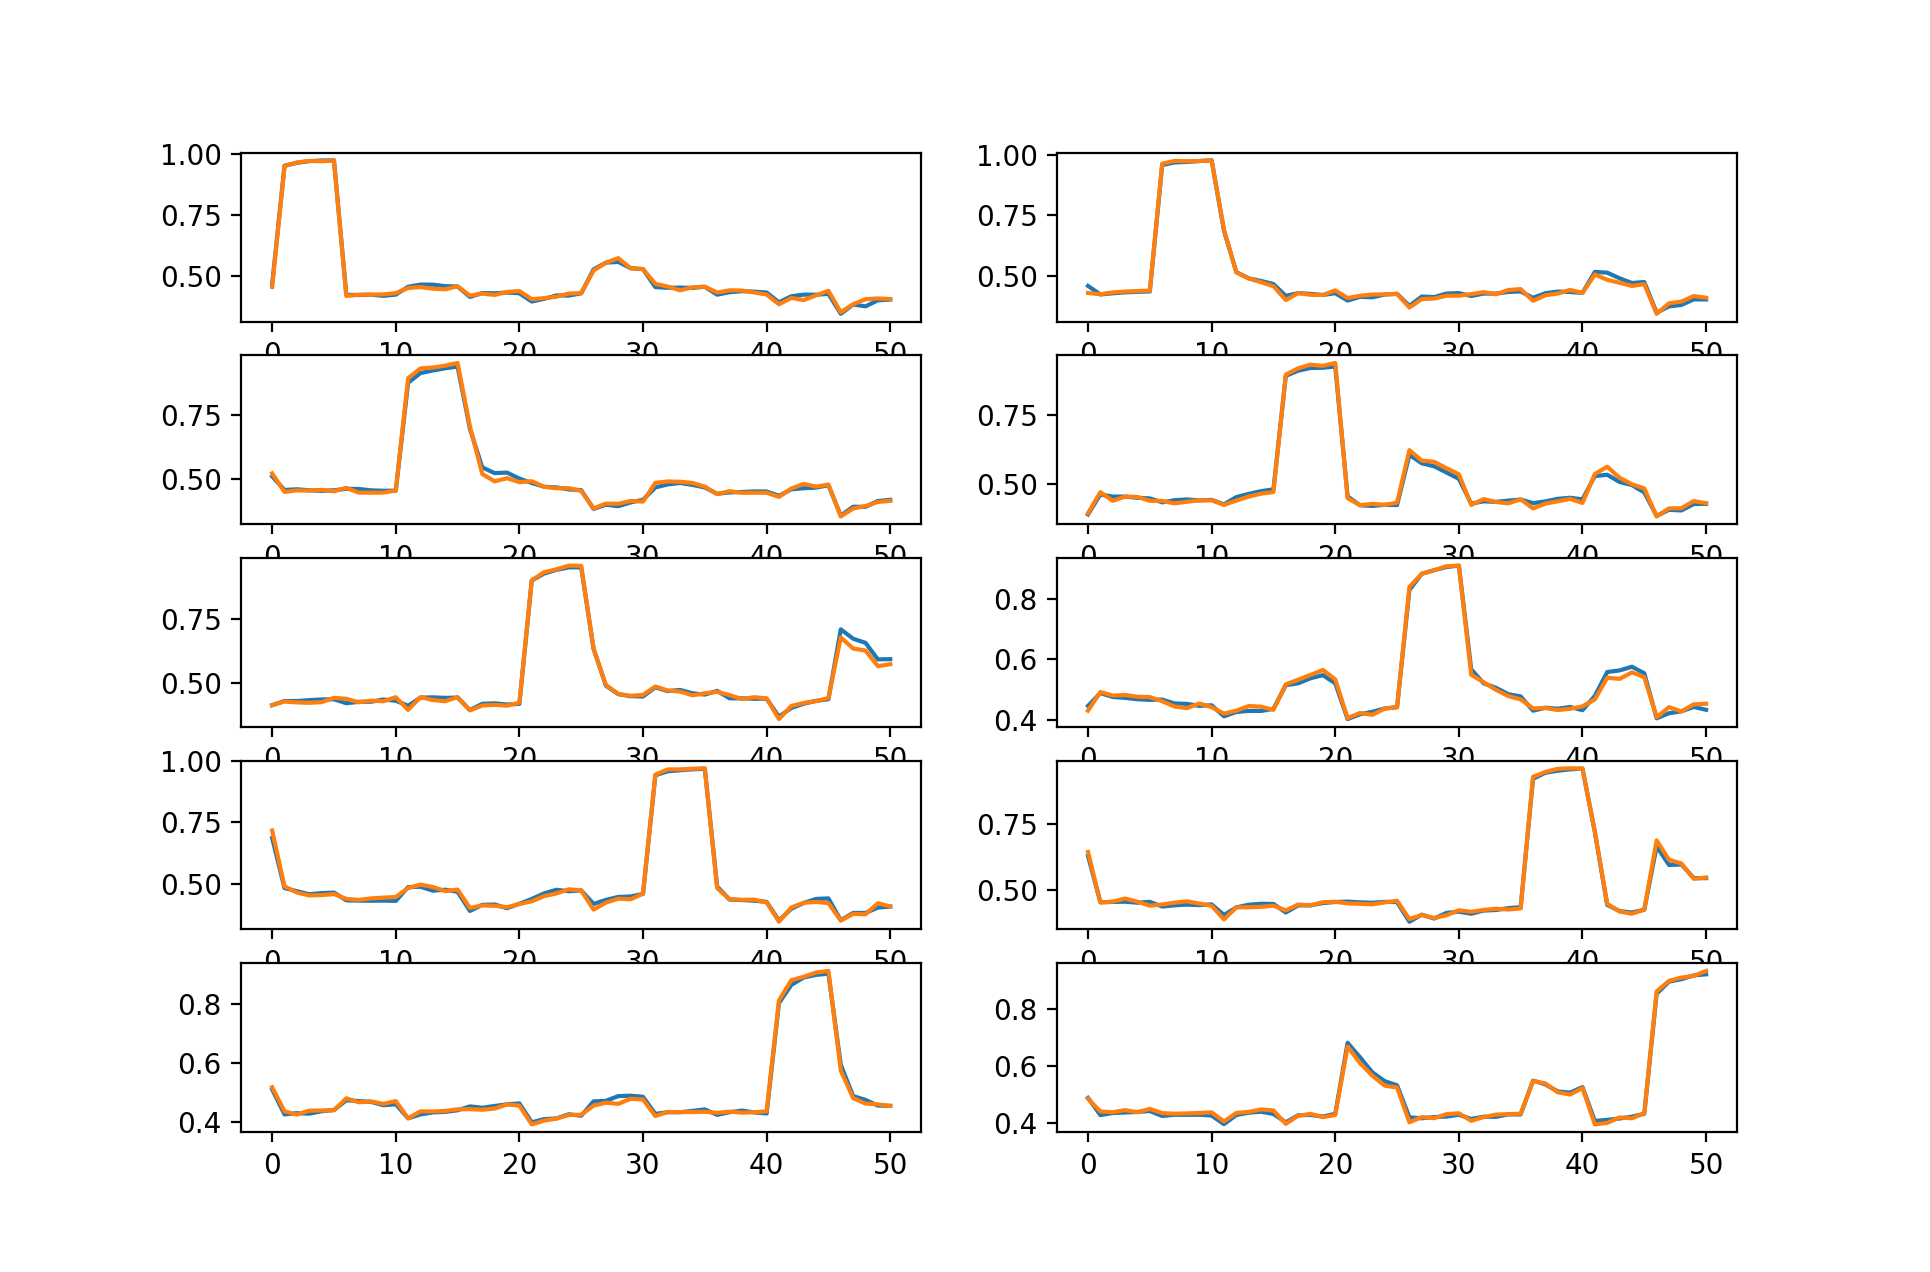

In [12]:
%matplotlib notebook
fig, ax = plt.subplots(nrows=5, ncols=2)
count = 0
for r in range(5):
    for c in range(2):
        ax[r,c].plot(data_dict['train_acc'][count])
        ax[r,c].plot(data_dict['valid_acc'][count])
        count += 1
plt.show()

In [30]:
t_acc = []
v_acc = []
for k,v in data_dict['train_acc'].items():
    t_acc.append(v[1])
for k,v in data_dict['valid_acc'].items():
    v_acc.append(v[1])
print('train accuracies after task 1:', t_acc)
print('\nvalidation accuracies after task 1:', v_acc)

train accuracies after task 1: [0.967558799675588, 0.4299929552659387, 0.45803140096618356, 0.4521662419133503, 0.43506894422720727, 0.4764758100310697, 0.45960412037972126, 0.4518840579710145, 0.4364931846344486, 0.4380513231756215]

validation accuracies after task 1: [0.9672048435923309, 0.4281015037593985, 0.454040404040404, 0.45145631067961167, 0.430824008138352, 0.473224043715847, 0.45191313340227507, 0.44954128440366975, 0.43161546085232905, 0.4323621227887617]


<IPython.core.display.Javascript object>


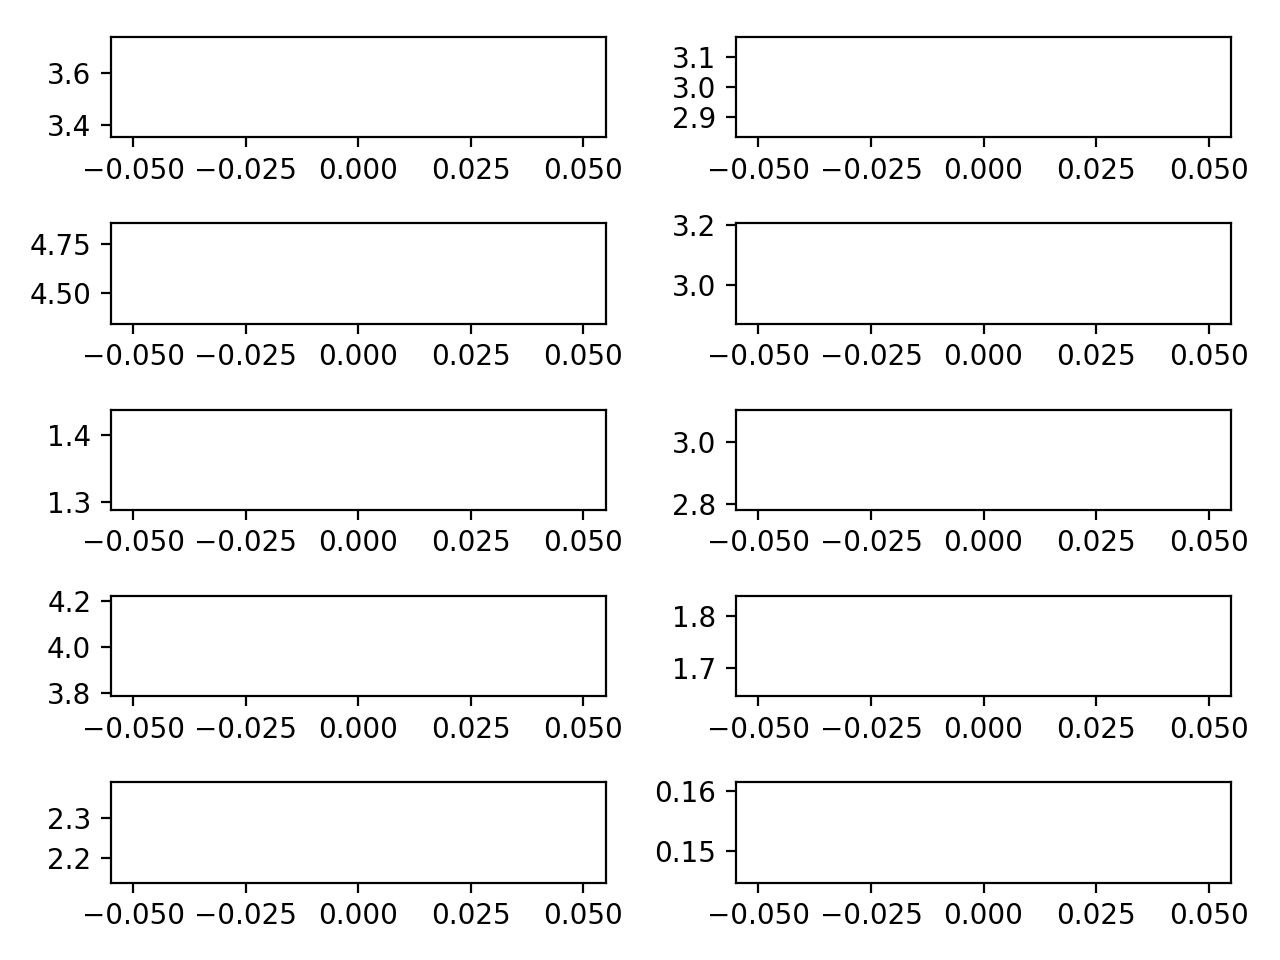

In [23]:
%matplotlib notebook
fig, ax = plt.subplots(nrows=5, ncols=2)
count = 0
for r in range(5):
    for c in range(2):
        ax[r,c].plot(data_dict['test_loss'][count])
#         ax[r,c].set(title='Task '+str(count)+' losses', xlabel='epochs', ylabel='loss')
        count += 1
fig.tight_layout()

plt.show()

In [27]:
data_dict['test_acc']

0.1443